In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
import yfinance as yf
import seaborn as sns
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

Import IHSG Data

In [ ]:
start_date = "2020-01-01"
end_date = "2025-11-05"

df = yf.Ticker("EPMT.JK")
df = df.history(start=start_date, end=end_date)
del df["Dividends"]
del df["Stock Splits"]
forecastData = df.copy()
df.tail(20)

,Open,High,Low,Close,Volume
Date,,,,,
2025-10-08 00:00:00+07:00,2240.0,2240.0,2230.0,2240.0,15400
2025-10-09 00:00:00+07:00,2230.0,2230.0,2210.0,2220.0,59200
2025-10-10 00:00:00+07:00,2230.0,2250.0,2220.0,2220.0,6500
2025-10-13 00:00:00+07:00,2220.0,2250.0,2200.0,2200.0,53400
2025-10-14 00:00:00+07:00,2250.0,2250.0,2220.0,2240.0,36800
2025-10-15 00:00:00+07:00,2240.0,2250.0,2210.0,2240.0,9500
2025-10-16 00:00:00+07:00,2250.0,2260.0,2240.0,2250.0,6800
2025-10-17 00:00:00+07:00,2260.0,2260.0,2250.0,2260.0,5200
2025-10-20 00:00:00+07:00,2240.0,2300.0,2240.0,2260.0,27200


Close Price Visualitation

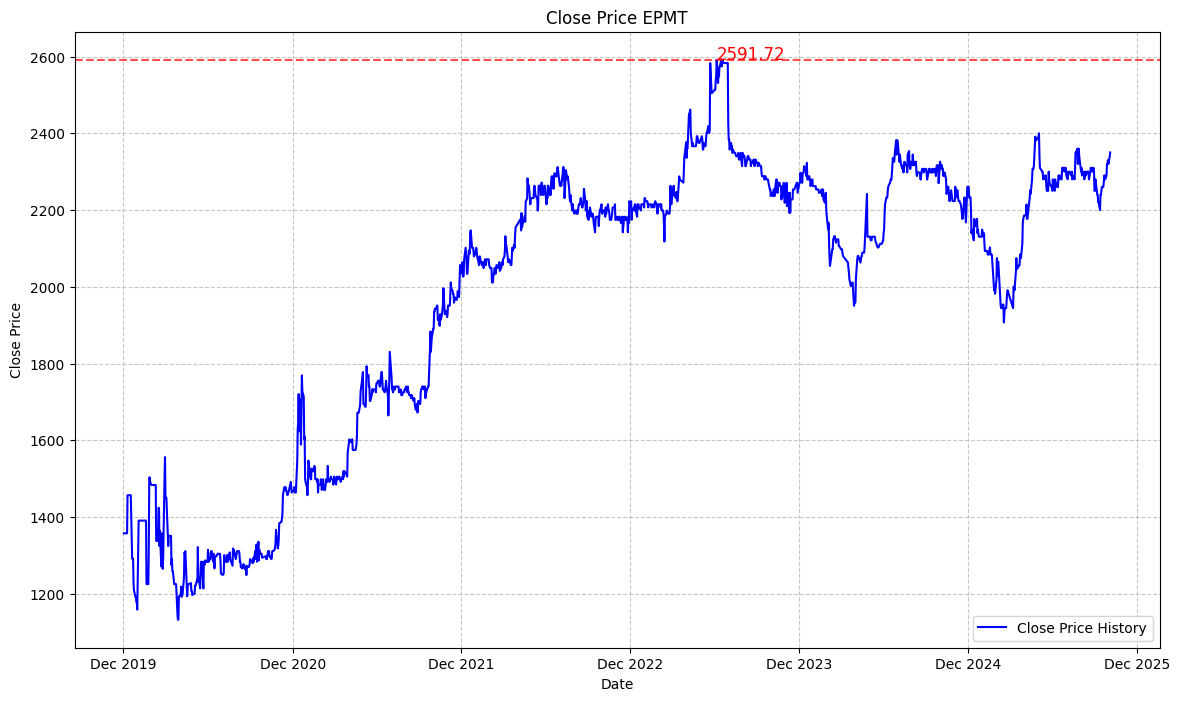

In [3]:
# Close price visualitation

plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x=df.index, y='Close', label='Close Price History', color='blue')

max_price = df['Close'].max()
max_price_date = df['Close'].idxmax()

# Annotate the hight price
plt.annotate(f'{max_price:.2f}',
             xy=(max_price_date, max_price),
             xytext=(max_price_date, max_price + 2),
             fontsize=12, color='red')

plt.axhline(max_price, linestyle='--', color='red', alpha=0.7)
plt.title('Close Price EPMT')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Preprocessing

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
scaled_data

array([[0.15428232],
       [0.15428232],
       [0.15428232],
       ...,
       [0.81380776],
       [0.82751256],
       [0.83436496]])

In [5]:
def create_sequences(df, sequence_length):
    sequences = []
    labels = []
    for i in range(len(df) - sequence_length):
        sequences.append(df[i:i + sequence_length])
        labels.append(df[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

In [6]:
sequence_length = 30

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [ ]:
X_train

array([[[0.15428232],
        [0.15428232],
        [0.15428232],
        ...,
        [0.17697095],
        [0.17697095],
        [0.17697095]],

       [[0.15428232],
        [0.15428232],
        [0.15428232],
        ...,
        [0.17697095],
        [0.17697095],
        [0.17697095]],

       [[0.15428232],
        [0.15428232],
        [0.15428232],
        ...,
        [0.17697095],
        [0.17697095],
        [0.17697095]],

       ...,

       [[0.77958306],
        [0.77958306],
        [0.78595817],
        ...,
        [0.81145877],
        [0.79870838],
        [0.83058409]],

       [[0.77958306],
        [0.78595817],
        [0.78595817],
        ...,
        [0.79870838],
        [0.83058409],
        [0.8369592 ]],

       [[0.78595817],
        [0.78595817],
        [0.78595817],
        ...,
        [0.83058409],
        [0.8369592 ],
        [0.81145877]]])

Training Data

In [ ]:
model = Sequential()

# First Layer lSTM
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second Layer LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense Layer
model.add(Dense(units=25))
model.add(Dense(units=1))

2025-11-05 22:58:01.479730: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-05 22:58:01.479760: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-05 22:58:01.479763: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-05 22:58:01.479778: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-05 22:58:01.479787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=126, validation_data=(X_test, y_test))

Epoch 1/100


2025-11-05 22:58:02.168393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.1108 - val_loss: 0.0380
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0191 - val_loss: 0.0268
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0129 - val_loss: 0.0026
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0093 - val_loss: 0.0028
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0070 - val_loss: 0.0014
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0035 - val_loss: 0.0011
E

Model Evaluation

In [10]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, predictions)
mape = mean_absolute_percentage_error(y_test_scaled, predictions) * 100

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Mean Squared Error: 2056.8933585835466
Root Mean Squared Error: 45.35298621462039
R2 Score: 0.833876330241551
Mean Absolute Percentage Error: 1.7114501903681503%


Prediction Future IHSG Price in 1 Month

In [11]:
# we choose last 30 days or data ke belakang which the reasons use (-) in sequence_length
last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)

X_predict = []
X_predict.append(last_30_days_scaled)

X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))
predicted_price = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted IHSG Price: {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted IHSG Price: 2339.359130859375


In [12]:
future_days = 30

last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)
future_predictions = []

for i in range(future_days):
    X_predict = []
    X_predict.append(last_30_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    future_predictions.append(predicted_price_unscaled[0, 0])

    new_scaled_data = np.append(last_30_days_scaled[1:], predicted_price, axis=0)
    last_30_days_scaled = new_scaled_data.reshape(-1, 1)

future_dates = pd.date_range(start=df.index[-1], periods=future_days+1, freq='D')[1:]

future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price EPMT': future_predictions})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

Visualitation IHSG Predictions

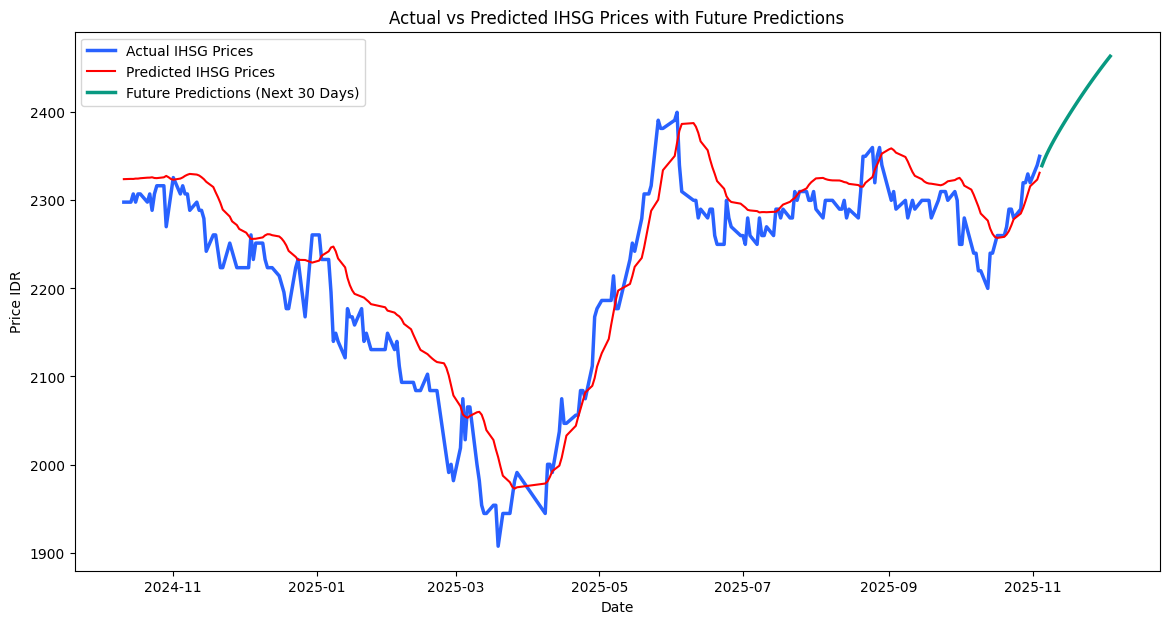

In [13]:
plt.figure(figsize=(14, 7))

plt.plot(df.index[-len(y_test_scaled):], y_test_scaled, label='Actual IHSG Prices', color='#2962ff', linewidth=2.5)
plt.plot(df.index[-len(y_test_scaled):], predictions, label='Predicted IHSG Prices', color='red', linewidth=1.5)
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 30 Days)', color='#089981', linewidth=2.5)

plt.title('Actual vs Predicted IHSG Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price IDR')
plt.legend()
plt.show()

In [14]:
# Transforming into DataFrame with pandas
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price EPMT': future_predictions
})

future_predictions_df.tail()

,Date,Predicted Price EPMT
25,2025-11-30 00:00:00+07:00,2449.737061
26,2025-12-01 00:00:00+07:00,2453.291016
27,2025-12-02 00:00:00+07:00,2456.798096
28,2025-12-03 00:00:00+07:00,2460.253174
29,2025-12-04 00:00:00+07:00,2463.666992


In [15]:
# calculate percentage change from the last actual close price
last_actual_price = df['Close'].iloc[-1]
percentage_change = ((future_predictions_df['Predicted Price EPMT'].iloc[-1] - last_actual_price) / last_actual_price) * 100

# Determine profit or loss
status = "profit" if percentage_change > 0 else "loss"

# print the percentage prediction
print(f"Percentage prediction for 30 days is: {status} {abs(percentage_change):.2f}%")

Percentage prediction for 30 days is: profit 4.84%
